# CNN 2D Basic Solution #3

This is 3rd version of https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai.

- Based on the 2nd version. https://www.kaggle.com/daisukelab/clf-to-multi-cnn-2d-basic-2-preprocessed-dataset
- Borrowing model from https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch
- Using preprocessed dataset. https://www.kaggle.com/daisukelab/fat2019_prep_mels1

# Important notice for final submission

This kernel is not preprocessing __test set__, then this doesn't work for final submission.
We should be ready for preprocessing new test set used in re-evaluation after deadline:

_"Note, as this competition is a Kernels-only, two-stage competition, following the final submission deadline for the competition, your kernel code will be re-run on a privately-held test set that is not provided to you. It is your model's score against this private test set that will determine your ranking on the private leaderboard and final standing in the competition. The leaderboard will be updated in the days following the competition's completion, and our team will announce that the re-run has been completed and leaderboard finalized with an announcement made on the competition forums."_

Link: https://www.kaggle.com/c/freesound-audio-tagging-2019/overview/timeline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython
import IPython.display
import PIL
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['fat2019_prep_mels1', 'freesound-audio-tagging-2019']


In [2]:
! ls ../input/fat2019_prep_mels1

mels_test.pkl		mels_train_noisy.pkl	    trn_noisy_best50s.csv
mels_train_curated.pkl	mels_trn_noisy_best50s.pkl


## Borrowed model

Thanks to https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch, borrowing simple model here.

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x
    
class Classifier(nn.Module):
    def __init__(self, num_classes=1000): # <======== modificaition to comply fast.ai
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # <======== modificaition to comply fast.ai
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        #x = torch.mean(x, dim=3)   # <======== modificaition to comply fast.ai
        #x, _ = torch.max(x, dim=2) # <======== modificaition to comply fast.ai
        x = self.avgpool(x)         # <======== modificaition to comply fast.ai
        x = self.fc(x)
        return x

## File/folder definitions

- `df` will handle training data.
- `test_df` will handle test data.

In [4]:
DATA = Path('../input/freesound-audio-tagging-2019')
PREPROCESSED = Path('../input/fat2019_prep_mels1')
WORK = Path('work')
Path(WORK).mkdir(exist_ok=True, parents=True)

CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_TRN_NOISY_BEST50S = PREPROCESSED/'trn_noisy_best50s.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'

MELS_TRN_CURATED = PREPROCESSED/'mels_train_curated.pkl'
MELS_TRN_NOISY = PREPROCESSED/'mels_train_noisy.pkl'
MELS_TRN_NOISY_BEST50S = PREPROCESSED/'mels_trn_noisy_best50s.pkl'
MELS_TEST = PREPROCESSED/'mels_test.pkl'

trn_curated_df = pd.read_csv(CSV_TRN_CURATED)
trn_noisy_df = pd.read_csv(CSV_TRN_NOISY)
trn_noisy50s_df = pd.read_csv(CSV_TRN_NOISY_BEST50S)
test_df = pd.read_csv(CSV_SUBMISSION)

#df = pd.concat([trn_curated_df, trn_noisy_df], ignore_index=True) # not enough memory
df = pd.concat([trn_curated_df, trn_noisy50s_df], ignore_index=True, sort=True)
test_df = pd.read_csv(CSV_SUBMISSION)

X_train = pickle.load(open(MELS_TRN_CURATED, 'rb')) + pickle.load(open(MELS_TRN_NOISY_BEST50S, 'rb'))

## Custom `open_image` for fast.ai library to load data from memory

- Important note: Random cropping 1 sec, this is working like augmentation.

In [5]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
import random

CUR_X_FILES, CUR_X = list(df.fname.values), X_train

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

## Follow multi-label classification

- Almost following fast.ai course: https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb
- But `pretrained=False`

In [6]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK, Path('..')/CSV_TRN_CURATED, folder='trn_curated')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats)
)

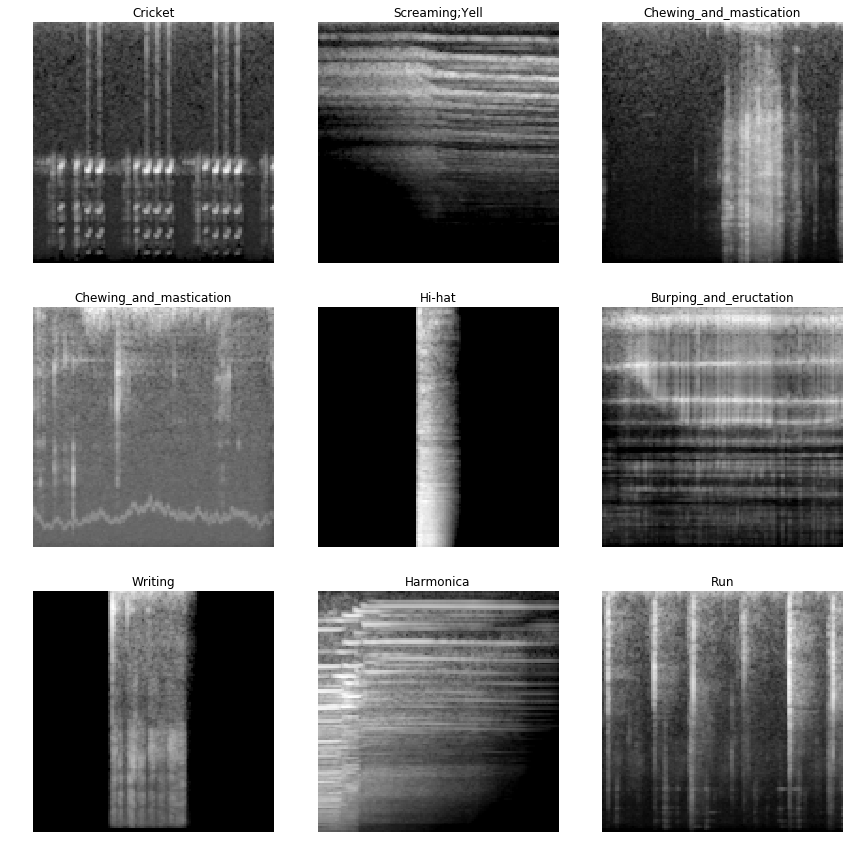

In [7]:
data.show_batch(3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


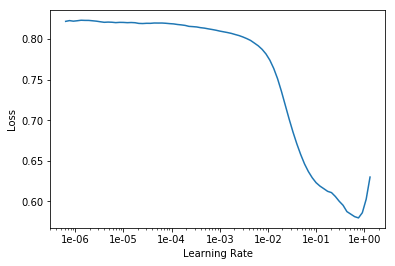

In [8]:
def borrowed_model(pretrained=False, **kwargs):
    return Classifier(**kwargs)

f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, borrowed_model, pretrained=False, metrics=[f_score])
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(10, slice(1e-6, 1e-1))

epoch,train_loss,valid_loss,fbeta,time
0,0.211520,0.088588,0.125189,00:11
1,0.103197,0.065835,0.078217,00:10
2,0.084114,0.081402,0.075298,00:10
3,0.091575,0.083517,0.091078,00:10
4,0.091874,0.073473,0.098824,00:10
5,0.082765,0.067018,0.167721,00:11
6,0.074063,0.060778,0.120315,00:10
7,0.066319,0.247797,0.096196,00:10
8,0.060520,0.053248,0.156751,00:10
9,0.057347,0.058143,0.180135,00:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


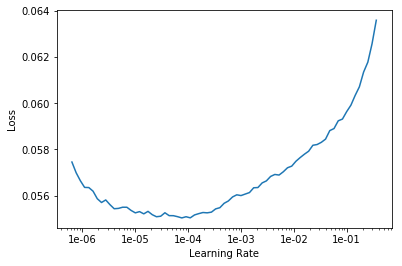

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(100, 3e-3)

epoch,train_loss,valid_loss,fbeta,time
0,0.055399,0.134952,0.213524,00:11
1,0.054516,0.054848,0.162931,00:11
2,0.053848,0.115507,0.194021,00:10
3,0.052839,0.047867,0.220974,00:10
4,0.052626,0.049677,0.215341,00:10
5,0.052609,0.051913,0.210084,00:10
6,0.052089,0.301585,0.200269,00:10
7,0.051618,0.123288,0.235827,00:10
8,0.052461,0.049122,0.218995,00:11
9,0.055173,0.599414,0.115540,00:10


In [12]:
learn.save('fat2019_fastai_cnn2d_stage-2')
learn.export()

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test prediction and making submission file simple
- Switch to test data.
- Overwrite results to sample submission; simple way to prepare submission file.

In [13]:
del X_train
X_test = pickle.load(open(MELS_TEST, 'rb'))
CUR_X_FILES, CUR_X = list(test_df.fname.values), X_test

test = ImageList.from_csv(WORK, Path('..')/CSV_SUBMISSION, folder='test')
learn = load_learner(WORK, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [14]:
test_df[learn.data.classes] = preds
test_df.to_csv('submission.csv', index=False)
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,3.672485e-08,1.735640e-11,1.932159e-11,3.158569e-09,4.344978e-07,9.713931e-08,4.763517e-10,2.926066e-04,4.819405e-08,1.650245e-10,1.284127e-09,4.698513e-09,5.130270e-08,8.949761e-09,3.388061e-07,3.024557e-10,1.929993e-08,3.079074e-04,2.878103e-10,1.175290e-07,2.303460e-10,2.520413e-04,1.071500e-05,2.763069e-08,8.264330e-10,4.986660e-06,5.603972e-09,2.635058e-10,2.624525e-05,3.845083e-13,2.414037e-10,2.371836e-08,1.830674e-07,1.603791e-06,4.028250e-04,1.608856e-05,1.995580e-08,3.679446e-09,1.439722e-08,...,8.663592e-07,5.185158e-03,1.093913e-02,4.098187e-05,3.467918e-09,2.306873e-09,3.684962e-07,4.434030e-12,2.353928e-10,2.443505e-10,2.581138e-08,6.336790e-08,2.375339e-09,2.254628e-10,5.988042e-11,3.040884e-04,1.042182e-08,3.625797e-02,3.907131e-07,3.079641e-04,5.395339e-11,2.637960e-07,4.196113e-11,4.841728e-09,1.344219e-06,3.583022e-08,7.047235e-07,2.190846e-12,1.334589e-08,1.160710e-08,3.616018e-08,2.213147e-09,1.867076e-07,1.270982e-08,1.304866e-05,1.109467e-07,1.244144e-04,1.087594e-05,1.473810e-07,7.361064e-06
1,0012633b.wav,1.240473e-01,2.291116e-05,1.449998e-05,6.504754e-04,2.253285e-05,4.022249e-05,3.891770e-04,1.503075e-04,2.148922e-06,8.297338e-07,2.168252e-04,2.141913e-02,4.434205e-03,1.878565e-05,9.294028e-06,3.698924e-05,9.757440e-08,4.274781e-07,2.935549e-05,6.096017e-05,5.349921e-08,3.519045e-05,2.128096e-06,7.240939e-04,5.483360e-05,8.194597e-07,1.372074e-06,2.473201e-05,8.492380e-08,7.673413e-03,1.246860e-04,1.032044e-05,6.510666e-06,3.770876e-05,1.357171e-08,1.151618e-05,6.924487e-05,8.638470e-07,3.573451e-07,...,1.000592e-03,8.799455e-06,9.511662e-04,1.567674e-06,1.515871e-05,4.630441e-04,1.322983e-03,2.955099e-08,1.924516e-05,3.850293e-05,1.918687e-03,3.839614e-02,5.770913e-05,6.051833e-06,5.323612e-02,2.046175e-09,1.254744e-02,1.995863e-07,2.107724e-06,1.147806e-06,9.726529e-06,2.868702e-06,1.965620e-05,2.233193e-05,1.157407e-04,3.028580e-03,1.018942e-04,3.635029e-05,5.642355e-07,1.085858e-09,1.781863e-04,1.902979e-03,3.722444e-08,3.100132e-03,5.423300e-06,5.643268e-03,2.758636e-07,8.636398e-06,1.235454e-05,3.585523e-01
2,001ed5f1.wav,8.058988e-05,3.125233e-05,2.205263e-05,1.947259e-05,6.559118e-05,1.243873e-04,1.095607e-07,2.689674e-06,7.022887e-07,2.806868e-07,2.622916e-06,1.273136e-07,6.386529e-06,2.512766e-06,8.903656e-06,2.610409e-07,1.969544e-06,7.436999e-08,2.198112e-06,2.433426e-04,1.067583e-05,3.030546e-04,6.420229e-07,1.747251e-05,2.048691e-03,3.210256e-06,1.788944e-05,7.554599e-04,1.895699e-05,3.714094e-06,9.103426e-07,2.782969e-06,1.246912e-08,5.979981e-05,1.085333e-05,8.809672e-07,1.334826e-07,1.946605e-06,6.966766e-06,...,1.752941e-07,5.393208e-05,1.025151e-04,1.891538e-07,2.273112e-02,3.959597e-06,9.860287e-07,9.929337e-08,2.653846e-04,2.856880e-07,4.362530e-02,1.443286e-05,9.190932e-03,6.283598e-07,2.013012e-05,3.775076e-06,4.303800e-01,7.660047e-06,3.748413e-08,1.997498e-07,6.939147e-09,6.533897e-06,4.327350e-05,4.669046e-04

## Visualizing activations

In [17]:
del X_test
X_train = pickle.load(open(MELS_TRN_CURATED, 'rb'))

CUR_X_FILES, CUR_X = list(df.fname.values), X_train
learn = cnn_learner(data, borrowed_model, pretrained=False, metrics=[f_score])
learn.load('fat2019_fastai_cnn2d_stage-2');

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


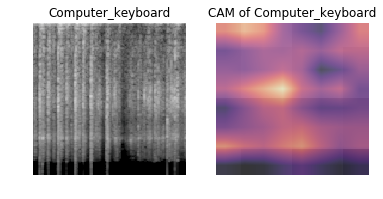

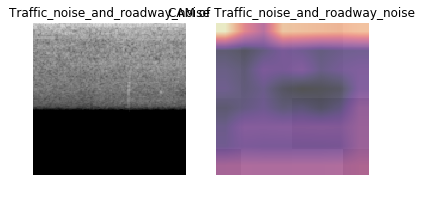

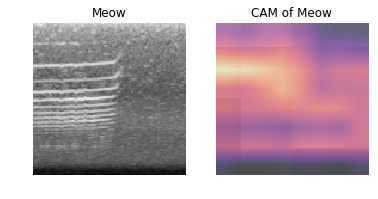

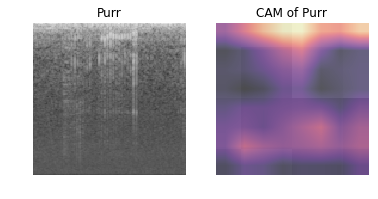

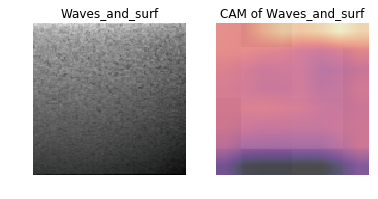

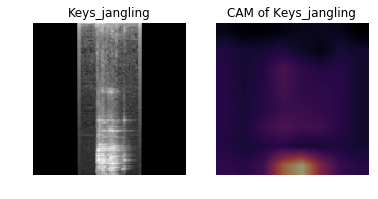

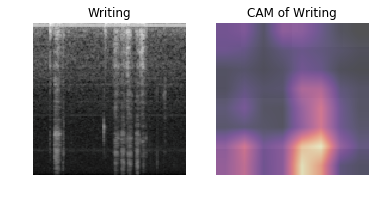

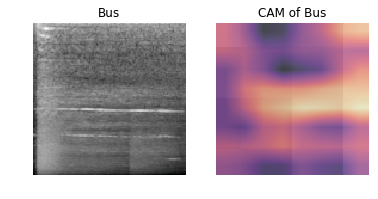

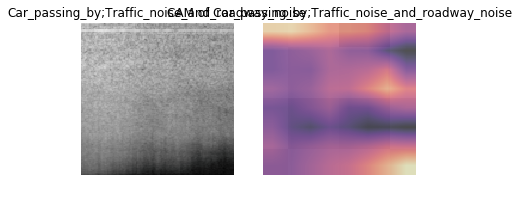

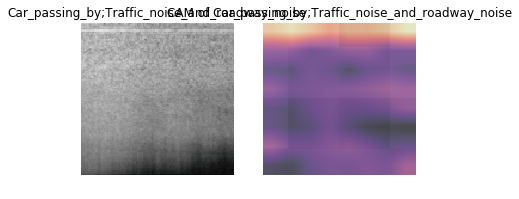

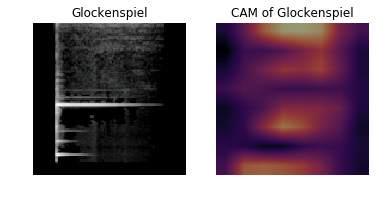

In [18]:
# Thanks to https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb
from fastai.callbacks.hooks import *

def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[0],img.shape[0],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(10):
    visualize_cnn_by_cam(learn, idx)